Imports for useful functions:

In [15]:
import csv
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import zCurve as z
import hilbert as h
import shutil

Functions for encoding data with Morton and Hilbert given the properties of our data:

In [16]:
def calculate_morton(output_dir, data_files, scales_dict, offsets_dict):
    data_files.sort()
    data_files.reverse()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ===============================
    # DATA FILE PROCESSING
    # ===============================
    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        # Get the file basename without extension
        file_basename = os.path.basename(file_path)
        results_filepath = os.path.join(output_dir, f"{file_basename}")
        
        data = pd.read_csv(file_path, sep=";")
        data['timestamp'] = data['Time (seconds)'] + data['Time (microseconds)'] / (10**6)

        # Transformation for speed and steering angle 

        ntimestamps = len(data['timestamp'])
        ndimensions = len(scales_dict)
        tmp_matrix = np.zeros((ntimestamps, ndimensions))

        for j, data_key in enumerate(scales_dict.keys()):
            tmp_matrix[:, j] = [int(i) for i in data[data_key] * scales_dict[data_key] + offsets_dict[data_key]]

        # -------------------------------
        # Build Morton (Z-order) Index (if chosen or if building both)
        # -------------------------------
        data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=10) for x, y in zip(tmp_matrix[:,0], tmp_matrix[:,1])]
        df = pd.DataFrame(data=data)
        df.to_csv(results_filepath, sep=";", index=False)

def calculate_hilbert(output_dir, data_files, scales_dict, offsets_dict):
    data_files.sort()
    data_files.reverse()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ===============================
    # DATA FILE PROCESSING
    # ===============================
    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        # Get the file basename without extension
        file_basename = os.path.basename(file_path)
        results_filepath = os.path.join(output_dir, f"{file_basename}")
        
        data = pd.read_csv(file_path, sep=";")
        data['timestamp'] = data['Time (seconds)'] + data['Time (microseconds)'] / (10**6)

        # Transformation for speed and steering angle 

        ntimestamps = len(data['timestamp'])
        ndimensions = len(scales_dict)
        tmp_matrix = np.zeros((ntimestamps, ndimensions))

        for j, data_key in enumerate(scales_dict.keys()):
            tmp_matrix[:, j] = [int(i) for i in data[data_key] * scales_dict[data_key] + offsets_dict[data_key]]

        # ===============================
        # Build Hilbert Index
        # ===============================
        data["Hilbert_Index"] = h.encode(np.ascontiguousarray(np.array([tmp_matrix[:,0], tmp_matrix[:,1]]).T), 2, 10)
        df = pd.DataFrame(data=data)
        df.to_csv(results_filepath, sep=";", index=False)

Some generic util functions:

In [17]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        files.sort()
        files.reverse()
        return files
    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def remove_files_in_folder(folder_path):
    shutil.rmtree(folder_path)
    os.mkdir(folder_path)

Functions for synthetic data generation

In [18]:
def generate_trajectory(parent_folder="results/synthetic_trajectories/", examplename="", speedchange=0, angle=-1, numexamples=5, fixed_initialspeed=None, fixed_angle=None, num_points=2500, noise_amp=3):
    delta_t = 10**4  # Time step in microseconds
    for example in range(1,numexamples+1):
        
        window_size= 150
        noisy_amplitude = np.random.normal(0, noise_amp, num_points)
        noisy_amplitude = np.convolve(noisy_amplitude, np.ones(window_size)/window_size, mode='same')
        noisy_amplitude[0] = 0
        
        window_size= 150
        noisy_amplitude1 = np.random.normal(0, noise_amp*5, num_points)
        noisy_amplitude1 = np.convolve(noisy_amplitude1, np.ones(window_size)/window_size, mode='same')
        noisy_amplitude1[0] = 0
        
        timestamp = 0
        lanechange_progress = 0
        was_lane_change = 0
        initial_speed = fixed_initialspeed if fixed_initialspeed else (21.5 - example * 1.4) 
        steering_angle_amplitude = fixed_angle if fixed_angle else (20 + example * 2) 
        
        filename = parent_folder+examplename+"_"+str(example)+".csv"
        with (open(filename, mode='w', newline='') as file):
                writer = csv.writer(file, delimiter=';')
                writer.writerow(["Time (seconds)", "Time (microseconds)", "Speed (m/s)", "Steering angle (deg)", "Lane change"])
                
                for i in range(0, num_points):                    
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0 else 1
                    
                    if was_lane_change != islanechange: lanechange_progress = 0
                    elif islanechange: lanechange_progress += 1
                    
                    turning_angle = - math.sin(timestamp*delta_t/10**10) * (steering_angle_amplitude+(example if not fixed_angle else 0)) * islanechange * angle + noisy_amplitude1[i]
                    
                    was_lane_change = islanechange
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0.2 else 1
                    
                    speed = initial_speed + lanechange_progress / 40 * speedchange * (1 if not speedchange else (example+1)/2) + noisy_amplitude[i]
                    
                    writer.writerow([int(timestamp / 1000000), timestamp % 1000000, speed, turning_angle, islanechange])
                    timestamp += delta_t
            


Generate synthetic trajectories using functions above:

In [19]:
parent_folder = "results/synthetic_trajectories_range_study/"
remove_files_in_folder(parent_folder)

exam = 0
for dir in ["left", "right"]:
    for fixed_initialspeed in range(1, 120, 10):
        for fixed_angle in range(1, 130, 10):
            generate_trajectory(parent_folder=parent_folder, examplename="lc"+dir+"_"+str(exam), fixed_initialspeed=fixed_initialspeed, fixed_angle=fixed_angle, angle=-1 if dir == "left" else 1, noise_amp=0, numexamples=1)
            exam += 1
            

data_files = get_files_in_folder(parent_folder)

offsets, scales = {"Speed (m/s)": 105}, {"Speed (m/s)": 4}
offsets["Steering angle (deg)"] = 150
scales["Steering angle (deg)"] = 1 

calculate_morton(output_dir=parent_folder+"/morton/", data_files=data_files,scales_dict=scales, offsets_dict=offsets)
calculate_hilbert(output_dir=parent_folder+"/hilbert/", data_files=data_files,scales_dict=scales, offsets_dict=offsets)

Plot synthetic data:

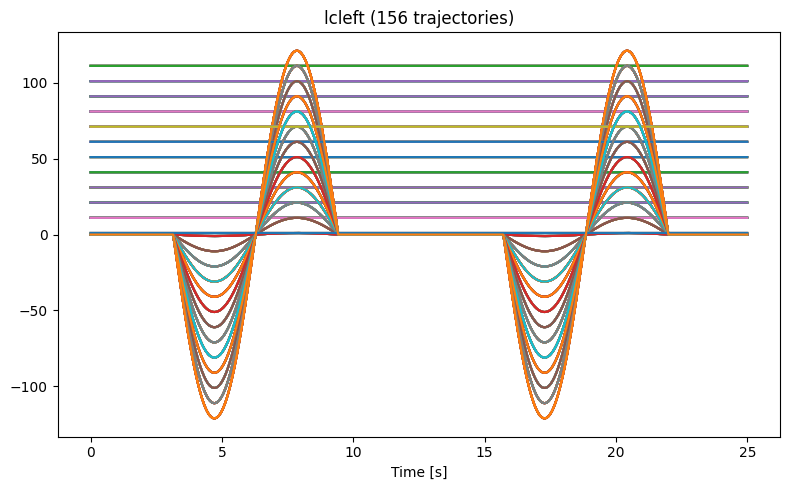

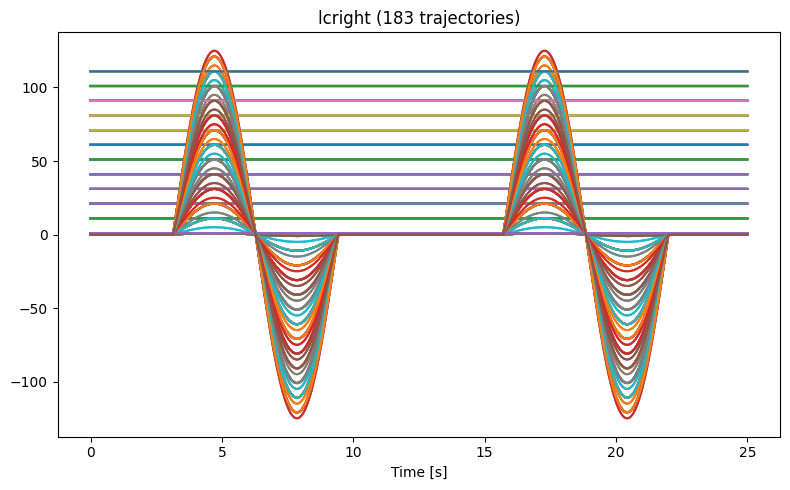

In [20]:
files = sorted(glob(os.path.join(parent_folder, "*.csv")))

# Group files by starting side (e.g., lcleft_ / lcright_)
grouped = {}
for f in files:
    base = os.path.basename(f)
    if not base.endswith(".csv"):
        continue

    # Extract start side and experiment type
    parts = base.replace(".csv", "").split("_")
    start = parts[0]
    
    if start not in grouped:
        grouped[start] = []
    grouped[start].append(f)

# Plot each group separately
for start_side, file_list in grouped.items():    
    fig, ax = plt.subplots(figsize=(10, 5))
    for f in file_list:
        data = pd.read_csv(f, sep=';')
        data['timestamp'] = data['Time (seconds)'] * 1_000_000 + data['Time (microseconds)']
        data['timestamp'] /= 1_000_000

        label = os.path.splitext(os.path.basename(f))[0]
        ax.plot(data['timestamp'], data['Speed (m/s)'], label=f"{label}")
        ax.plot(data['timestamp'], data['Steering angle (deg)'], label=f"{label}")

    ax.set_title(f"{start_side} ({len(file_list)} trajectories)")
    ax.set_xlabel("Time [s]")
    # ax.set_ylim([-50, 50])
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space for legend
    plt.show()

Plot CSPs for files above:

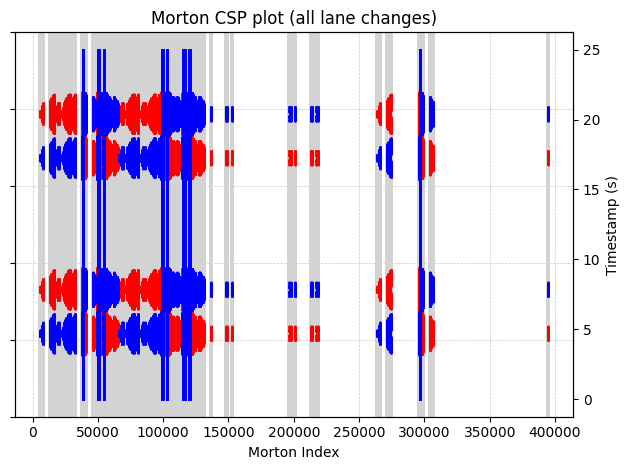

In [21]:
data_files = get_files_in_folder(parent_folder+"/morton/")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for file_path in data_files:
    if ".csv" not in file_path:
        continue

    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    data = pd.read_csv(file_path, sep=";")
    
    ax1.eventplot(data['Morton_Index'], orientation='horizontal', colors=["lightgray"], alpha=0.4, lineoffsets=0.5)  
    ax2.scatter(data['Morton_Index'], data['timestamp'], color='red' if "right" in file_basename else "blue", s=0.5, alpha=0.8, label="Timestamps")

ax1.set_xlabel("Morton Index")
ax1.set_ylim((0, 1))
ax2.set_ylabel("Timestamp (s)")
ax1.tick_params(axis='y',gridOn=False, label1On=False, label2On=False)
plt.title(f"Morton CSP plot (all lane changes)")
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()